In [25]:
# made by Gibeom LEE, HI LAB
# Vpp finder와 기능은 같음. 다만, 일부분 피크를 발췌해서 정리해줌!

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [27]:
# 폴더 경로
folder_path = r"C:\Users\user\Desktop\Drive파일\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\4. Data measurement\250910_내구도\csv파일\PDMS-OTS-C30"

# 사용자 설정값
prominence_ratio = 0.3   # 표준편차(std) * 비율로 prominence 기준 설정
min_prominence   = 0.1   # prominence 하한 
min_distance_sec = 0.15  # 인접 피크 최소 간격(초)
snr_threshold    = 1     # SNR 기준
min_relative_height = 0.05  # 전체 최대 진폭 대비 최소 비율
window_peaks = 5         # <<<< 연속 피크 개수(요청: 5개) # 이 코드의 핵심이죠?

# 그래프 Y축
y_range = (-40, 10)

RealPOC30_00k_lowfreq_Vpp: 40.63 V
RealPOC30_00k_lowfreq_Peak number: 22개
RealPOC30_00k_lowfreq_표준편차: 10.44
RealPOC30_00k_lowfreq_주파수: 2.30 Hz
👉 RealPOC30_00k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 221.36
   - 발췌 평균 Vpp: 49.73 V (표준편차: 2.20 V)
   - 발췌 평균 주파수: 2.15 Hz


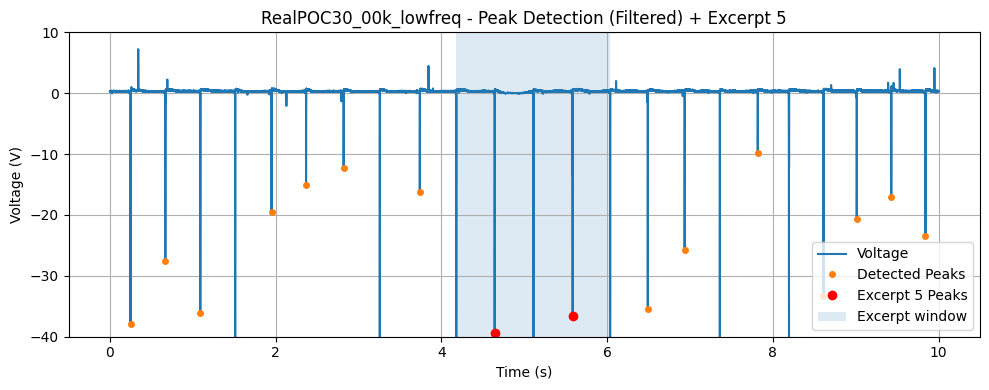

RealPOC30_01k_lowfreq_Vpp: 31.45 V
RealPOC30_01k_lowfreq_Peak number: 22개
RealPOC30_01k_lowfreq_표준편차: 11.98
RealPOC30_01k_lowfreq_주파수: 2.31 Hz
👉 RealPOC30_01k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 201.88
   - 발췌 평균 Vpp: 44.07 V (표준편차: 0.38 V)
   - 발췌 평균 주파수: 2.43 Hz


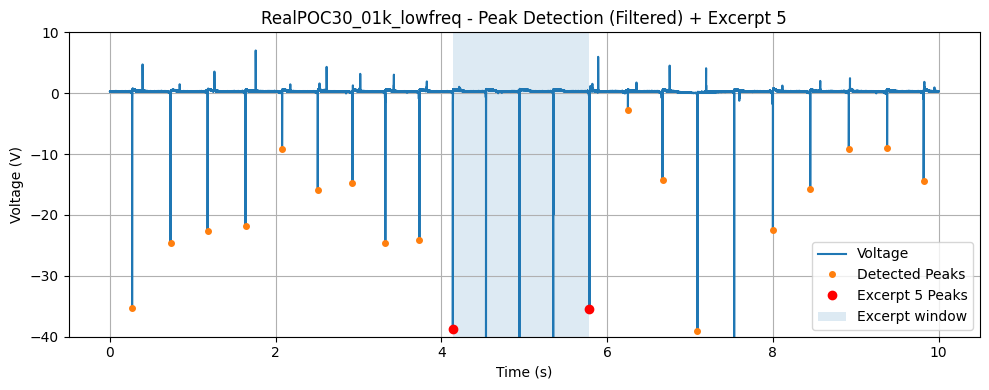

RealPOC30_02k_lowfreq_Vpp: 40.31 V
RealPOC30_02k_lowfreq_Peak number: 22개
RealPOC30_02k_lowfreq_표준편차: 6.46
RealPOC30_02k_lowfreq_주파수: 2.32 Hz
👉 RealPOC30_02k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 211.86
   - 발췌 평균 Vpp: 45.66 V (표준편차: 2.81 V)
   - 발췌 평균 주파수: 2.45 Hz


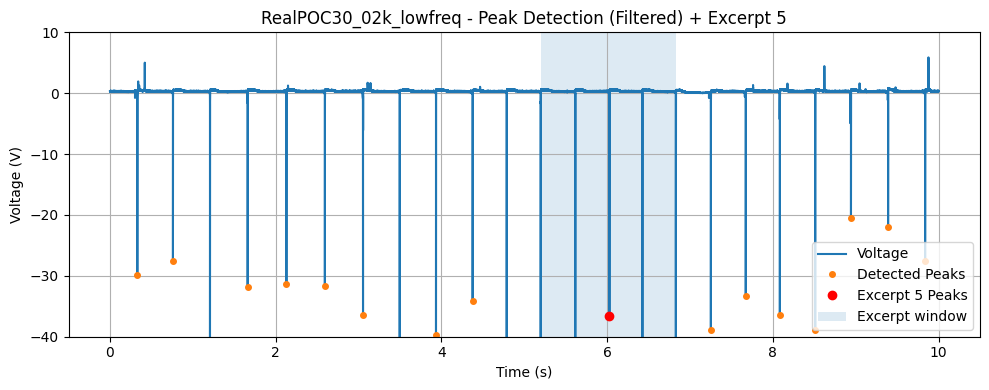

RealPOC30_03k_lowfreq_Vpp: 36.63 V
RealPOC30_03k_lowfreq_Peak number: 20개
RealPOC30_03k_lowfreq_표준편차: 8.19
RealPOC30_03k_lowfreq_주파수: 2.15 Hz
👉 RealPOC30_03k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 193.19
   - 발췌 평균 Vpp: 40.24 V (표준편차: 3.39 V)
   - 발췌 평균 주파수: 1.96 Hz


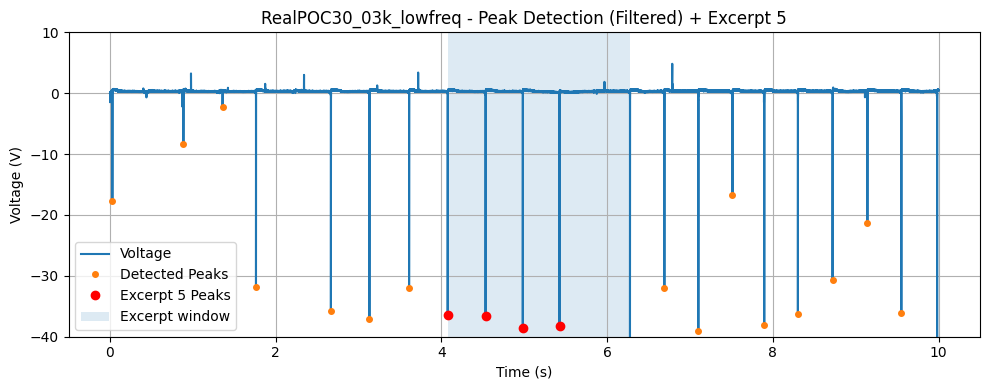

RealPOC30_04k_lowfreq_Vpp: 41.13 V
RealPOC30_04k_lowfreq_Peak number: 22개
RealPOC30_04k_lowfreq_표준편차: 4.69
RealPOC30_04k_lowfreq_주파수: 2.23 Hz
👉 RealPOC30_04k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 207.25
   - 발췌 평균 Vpp: 43.56 V (표준편차: 0.98 V)
   - 발췌 평균 주파수: 2.38 Hz


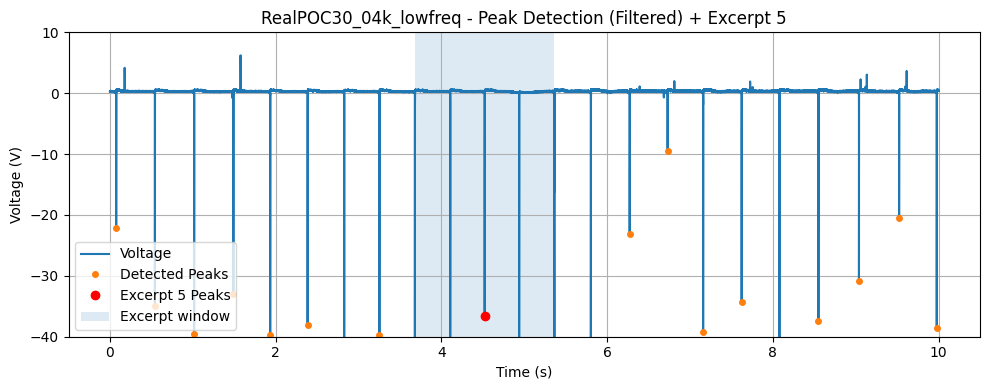

RealPOC30_05k_lowfreq_Vpp: 28.69 V
RealPOC30_05k_lowfreq_Peak number: 20개
RealPOC30_05k_lowfreq_표준편차: 7.44
RealPOC30_05k_lowfreq_주파수: 2.27 Hz
👉 RealPOC30_05k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 149.21
   - 발췌 평균 Vpp: 31.52 V (표준편차: 1.58 V)
   - 발췌 평균 주파수: 2.46 Hz


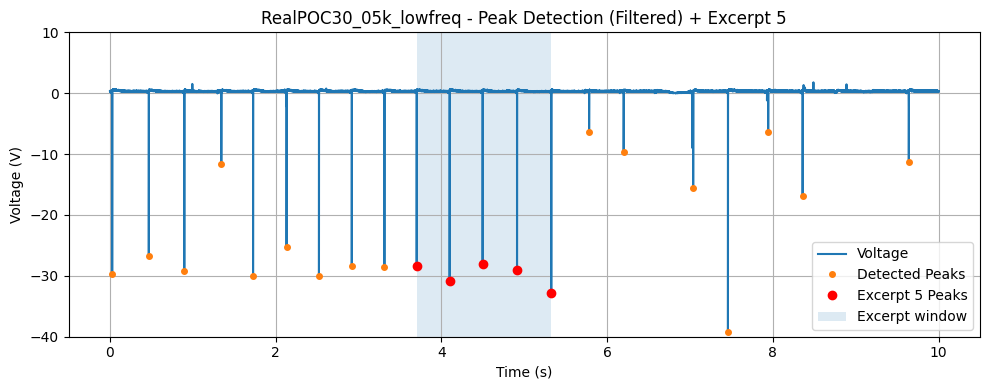

RealPOC30_06k_lowfreq_Vpp: 33.13 V
RealPOC30_06k_lowfreq_Peak number: 22개
RealPOC30_06k_lowfreq_표준편차: 4.01
RealPOC30_06k_lowfreq_주파수: 2.33 Hz
👉 RealPOC30_06k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 160.66
   - 발췌 평균 Vpp: 34.05 V (표준편차: 1.18 V)
   - 발췌 평균 주파수: 2.28 Hz


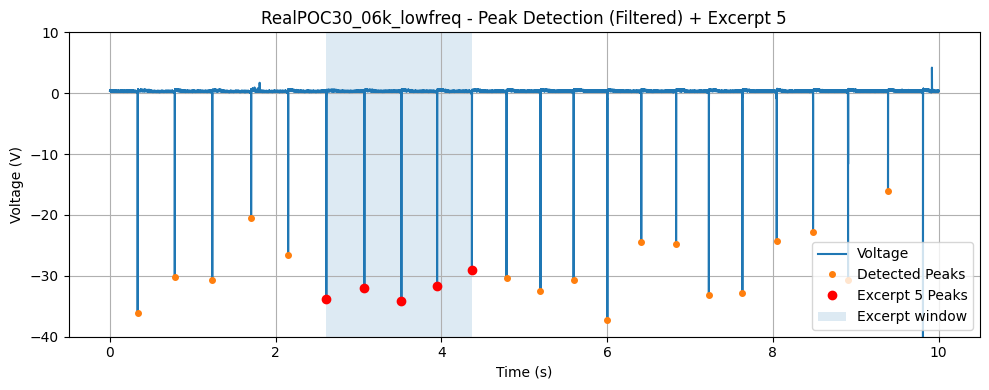

RealPOC30_07k_lowfreq_Vpp: 30.71 V
RealPOC30_07k_lowfreq_Peak number: 22개
RealPOC30_07k_lowfreq_표준편차: 6.51
RealPOC30_07k_lowfreq_주파수: 2.32 Hz
👉 RealPOC30_07k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 171.95
   - 발췌 평균 Vpp: 35.48 V (표준편차: 0.88 V)
   - 발췌 평균 주파수: 2.33 Hz


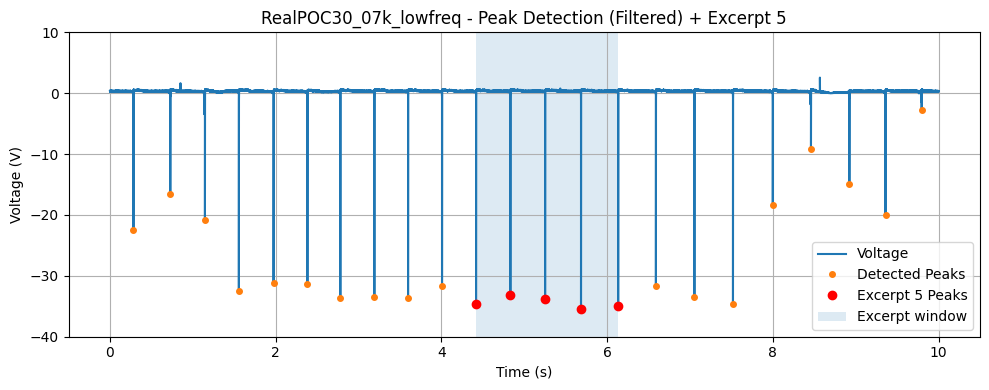

RealPOC30_08k_lowfreq_Vpp: 31.80 V
RealPOC30_08k_lowfreq_Peak number: 26개
RealPOC30_08k_lowfreq_표준편차: 3.92
RealPOC30_08k_lowfreq_주파수: 2.74 Hz
👉 RealPOC30_08k_lowfreq 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 168.42
   - 발췌 평균 Vpp: 35.77 V (표준편차: 2.94 V)
   - 발췌 평균 주파수: 2.52 Hz


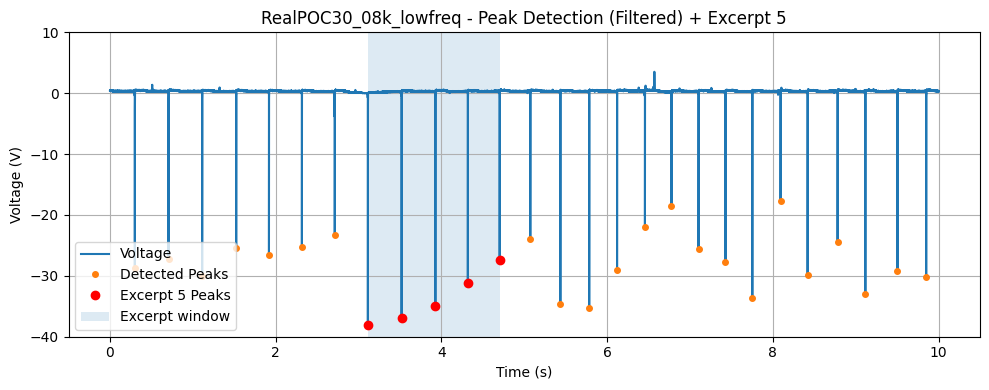

RealPOC30_09k_Vpp: 22.49 V
RealPOC30_09k_Peak number: 21개
RealPOC30_09k_표준편차: 5.78
RealPOC30_09k_주파수: 2.24 Hz
👉 RealPOC30_09k 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 129.10
   - 발췌 평균 Vpp: 27.35 V (표준편차: 3.46 V)
   - 발췌 평균 주파수: 2.20 Hz


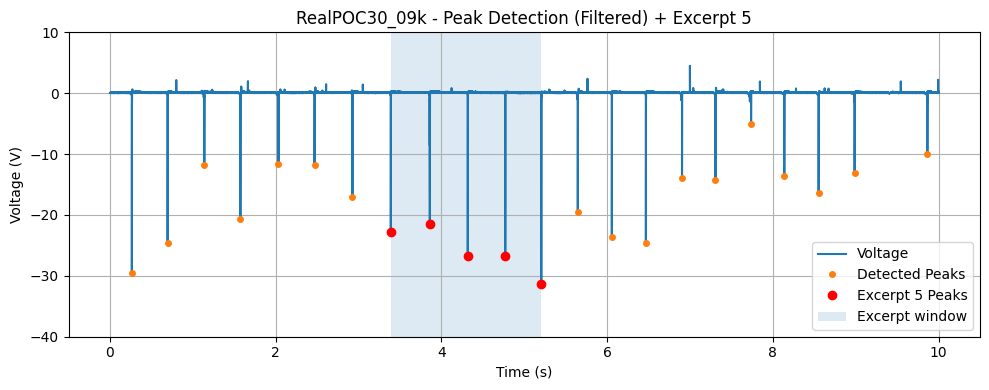

RealPOC30_10k_Vpp: 20.85 V
RealPOC30_10k_Peak number: 20개
RealPOC30_10k_표준편차: 5.15
RealPOC30_10k_주파수: 2.31 Hz
👉 RealPOC30_10k 발췌(연속 5개) 정보
   - 합계(피크 크기 합): 122.21
   - 발췌 평균 Vpp: 25.82 V (표준편차: 2.50 V)
   - 발췌 평균 주파수: 2.43 Hz


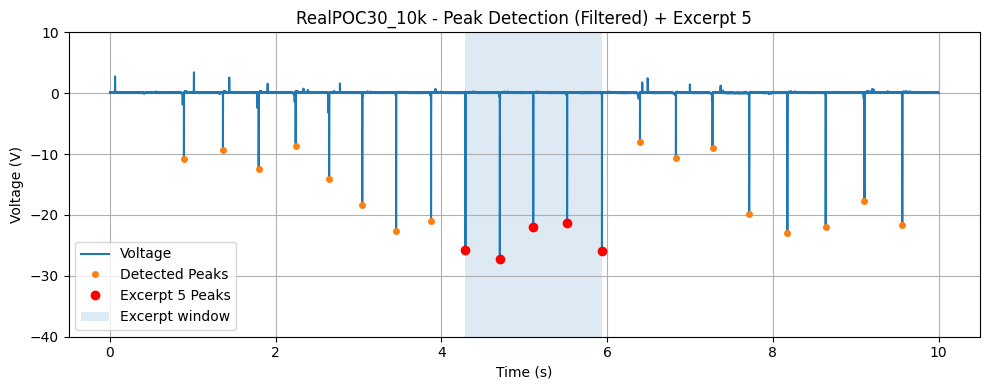


🎯 모든 파일 발췌 결과 요약 (연속 5개 피크 기준)
RealPOC30_00k_lowfreq.csv | Vpp: 49.73 V | 표준편차: 2.20 V | 주파수: 2.15 Hz
RealPOC30_01k_lowfreq.csv | Vpp: 44.07 V | 표준편차: 0.38 V | 주파수: 2.43 Hz
RealPOC30_02k_lowfreq.csv | Vpp: 45.66 V | 표준편차: 2.81 V | 주파수: 2.45 Hz
RealPOC30_03k_lowfreq.csv | Vpp: 40.24 V | 표준편차: 3.39 V | 주파수: 1.96 Hz
RealPOC30_04k_lowfreq.csv | Vpp: 43.56 V | 표준편차: 0.98 V | 주파수: 2.38 Hz
RealPOC30_05k_lowfreq.csv | Vpp: 31.52 V | 표준편차: 1.58 V | 주파수: 2.46 Hz
RealPOC30_06k_lowfreq.csv | Vpp: 34.05 V | 표준편차: 1.18 V | 주파수: 2.28 Hz
RealPOC30_07k_lowfreq.csv | Vpp: 35.48 V | 표준편차: 0.88 V | 주파수: 2.33 Hz
RealPOC30_08k_lowfreq.csv | Vpp: 35.77 V | 표준편차: 2.94 V | 주파수: 2.52 Hz
RealPOC30_09k.csv | Vpp: 27.35 V | 표준편차: 3.46 V | 주파수: 2.20 Hz
RealPOC30_10k.csv | Vpp: 25.82 V | 표준편차: 2.50 V | 주파수: 2.43 Hz

📊 발췌 구간 전체 평균 Vpp: 37.57 V
📉 발췌 구간 표준편차(Vpp): 7.73 V
🎵 발췌 구간 평균 주파수: 2.33 Hz


In [28]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []
file_std_values = []
all_freq_values = []

# (선택) 발췌 요약 모음 저장용
excerpt_mean_vpp_list = []
excerpt_std_vpp_list  = []
excerpt_mean_freq_list = []

for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 음의 피크 검출
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)
        raw_peaks, properties = find_peaks(-voltage, prominence=prom, distance=distance)

        # 피크 필터링(SNR/상대높이)
        max_amplitude = np.max(-voltage) if len(voltage) > 0 else 0.0
        final_peaks = []
        for i in raw_peaks:
            left  = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = -voltage[i]
            if signal > max_amplitude * min_relative_height and (signal / local_noise) > snr_threshold:
                final_peaks.append(i)
        final_peaks = np.array(final_peaks, dtype=int)
        peak_times  = time[final_peaks]

        # 전체 Vpp 계산(연속 피크 사이 구간의 Vpp)
        vpp_list = []
        for i in range(len(final_peaks) - 1):
            s = final_peaks[i]
            e = final_peaks[i + 1]
            vpp = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
            vpp_list.append(vpp)
        mean_vpp = np.mean(vpp_list) if vpp_list else 0.0
        std_vpp  = np.std(vpp_list, ddof=1) if len(vpp_list) > 1 else 0.0

        # 전체 평균 주파수
        if len(peak_times) < 2:
            mean_freq = 0.0
        else:
            periods = np.diff(peak_times)
            mean_freq = float(np.mean(1.0 / periods))

        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Vpp: {mean_vpp:.2f} V")
        print(f"{base_name}_Peak number: {len(vpp_list):.0f}개")
        print(f"{base_name}_표준편차: {std_vpp:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        # 저장
        all_vpp_values.append(mean_vpp)
        file_std_values.append(std_vpp)
        all_freq_values.append(mean_freq)

        # ====== [신규 기능] 연속된 5개 피크 중 합이 최대인 집합 발췌 ======
        if len(final_peaks) >= window_peaks:
            # 각 피크의 "크기"는 음의 피크이므로 -voltage[peak]
            peak_mags = -voltage[final_peaks].astype(float)

            # 누적합을 이용해 길이 window_peaks의 구간합 계산
            csum = np.cumsum(peak_mags)
            # sums[k] = sum(peak_mags[k : k+window_peaks])
            sums = csum[window_peaks - 1:] - np.concatenate(([0.0], csum[:-window_peaks]))
            best_start_idx = int(np.argmax(sums))
            best_end_idx   = best_start_idx + window_peaks  # 슬라이스 끝 인덱스(포함X)

            # 발췌된 5개 피크의 "원본 인덱스"
            excerpt_peak_idx = final_peaks[best_start_idx:best_end_idx]
            excerpt_peak_times = time[excerpt_peak_idx]
            excerpt_peak_mags  = -voltage[excerpt_peak_idx]

            # 발췌 구간의 Vpp(연속 5개 피크 사이 구간은 4개)
            excerpt_vpp = []
            for j in range(window_peaks - 1):
                s = excerpt_peak_idx[j]
                e = excerpt_peak_idx[j + 1]
                vpp_seg = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
                excerpt_vpp.append(vpp_seg)
            excerpt_mean_vpp = float(np.mean(excerpt_vpp)) if excerpt_vpp else 0.0
            excerpt_std_vpp  = float(np.std(excerpt_vpp, ddof=1)) if len(excerpt_vpp) > 1 else 0.0

            # 발췌 구간의 평균 주파수(5개 피크 → 4개 구간)
            if len(excerpt_peak_times) >= 2:
                excerpt_periods = np.diff(excerpt_peak_times)
                excerpt_mean_freq = float(np.mean(1.0 / excerpt_periods))
            else:
                excerpt_mean_freq = 0.0

            # 콘솔 출력
            print(f"👉 {base_name} 발췌(연속 {window_peaks}개) 정보")
            #print(f"   - 피크 시간(s): {', '.join([f'{t:.4f}' for t in excerpt_peak_times])}")
            #print(f"   - 피크 크기(V, -voltage): {', '.join([f'{m:.2f}' for m in excerpt_peak_mags])}")
            print(f"   - 합계(피크 크기 합): {np.sum(excerpt_peak_mags):.2f}")
            print(f"   - 발췌 평균 Vpp: {excerpt_mean_vpp:.2f} V (표준편차: {excerpt_std_vpp:.2f} V)")
            print(f"   - 발췌 평균 주파수: {excerpt_mean_freq:.2f} Hz")

            # (선택) 전체 요약용 리스트에 저장
            excerpt_mean_vpp_list.append(excerpt_mean_vpp)
            excerpt_std_vpp_list.append(excerpt_std_vpp)
            excerpt_mean_freq_list.append(excerpt_mean_freq)
           

            # ====== 그래프: 전체 + 발췌구간 강조 ======
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage')
            # 전체 검출 피크(회색)
            if len(final_peaks) > 0:
                plt.plot(time[final_peaks], voltage[final_peaks], 'o', ms=4, label='Detected Peaks')
            # 발췌된 5개 피크(빨간 점)
            plt.plot(time[excerpt_peak_idx], voltage[excerpt_peak_idx], 'ro', ms=6, label=f'Excerpt {window_peaks} Peaks')
            # 발췌 구간 배경 밴드
            t0, t1 = time[excerpt_peak_idx[0]], time[excerpt_peak_idx[-1]]
            plt.axvspan(t0, t1, alpha=0.15, label='Excerpt window')

            plt.title(f"{base_name} - Peak Detection (Filtered) + Excerpt {window_peaks}")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            # 기존 그래프(발췌 불가 시 기본만 표시)
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage', color='gray')
            if len(final_peaks) > 0:
                plt.plot(time[final_peaks], voltage[final_peaks], 'ro', ms=4, label='Detected Peaks')
            plt.title(f"{base_name} - Peak Detection (Filtered) (not enough peaks for excerpt)")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print(f"🎯 모든 파일 발췌 결과 요약 (연속 {window_peaks}개 피크 기준)")
for i in range(len(excerpt_mean_vpp_list)):
    print(f"{csv_files[i]} | Vpp: {excerpt_mean_vpp_list[i]:.2f} V | "
          f"표준편차: {excerpt_std_vpp_list[i]:.2f} V | "
          f"주파수: {excerpt_mean_freq_list[i]:.2f} Hz")

# 전체 평균 요약
if excerpt_mean_vpp_list:
    print("\n==============================")
    print(f"📊 발췌 구간 전체 평균 Vpp: {np.mean(excerpt_mean_vpp_list):.2f} V")
    print(f"📉 발췌 구간 표준편차(Vpp): {np.std(excerpt_mean_vpp_list, ddof=1) if len(excerpt_mean_vpp_list) > 1 else 0.0:.2f} V")
    print(f"🎵 발췌 구간 평균 주파수: {np.mean(excerpt_mean_freq_list):.2f} Hz")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")
